# Case-Control Finder  
## Finds cases and controls for a given condition within the Sequence Read Archive

__Import dependencies and load data__

In [1]:
%load_ext rpy2.ipython

In [2]:
%%bash
wget https://cran.r-project.org/src/contrib/rjson_0.2.20.tar.gz
R CMD INSTALL rjson_0.2.20.tar.gz

x86_64-conda_cos6-linux-gnu-c++  -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -I/opt/conda/include -fdebug-prefix-map==/usr/local/src/conda/- -fdebug-prefix-map==/usr/local/src/conda-prefix  -c dump.cpp -o dump.o
x86_64-conda_cos6-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -I/opt/conda/include -fdebug-prefix-map==/usr/local/src/conda/- -fdebug-prefix-map==/usr/local/src/conda-prefix  -c parser.c -o parser.o
x86_64-conda_cos6-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib 

--2019-09-30 19:36:50--  https://cran.r-project.org/src/contrib/rjson_0.2.20.tar.gz
Resolving cran.r-project.org (cran.r-project.org)... 137.208.57.37
Connecting to cran.r-project.org (cran.r-project.org)|137.208.57.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99600 (97K) [application/x-gzip]
Saving to: ‘rjson_0.2.20.tar.gz.119’

     0K .......... .......... .......... .......... .......... 51%  201K 0s
    50K .......... .......... .......... .......... .......   100%  381K=0.4s

2019-09-30 19:36:51 (261 KB/s) - ‘rjson_0.2.20.tar.gz.119’ saved [99600/99600]

* installing to library ‘/opt/conda/lib/R/library’
* installing *source* package ‘rjson’ ...
** package ‘rjson’ successfully unpacked and MD5 sums checked
** libs
installing to /opt/conda/lib/R/library/rjson/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package ca

In [3]:
%%R
library(rjson)

In [4]:
import json
import pandas as pd
from functions import *
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
%%R
metadata_file_tsv <- read.table(file = "./data/experiment_to_terms.tsv", header = FALSE, sep = "\t")

In [6]:
%%R
R.Version()


Error in R.version() : could not find function "R.version"


/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in R.version() : could not find function "R.version"

  warnings.warn(x, RRuntimeWarning)


__1. Do you have a set of samples that you would like to restrict the retrieval to?__ 

These may be SRA samples that you have preprocessed and/or have access to expressiond data. If so, point `available_data_f` to a JSON file containing a list of SRA experiment accessions. See `./data/experiments_in_hackathon_data.json` for an example.

In [7]:
available_data_f = None  ## <-- INPUT HERE

r = load_metadata(available_data_f)
sample_to_terms = r[0]
term_name_to_id = r[1]
sample_to_type = r[2]
sample_to_study = r[3]
sample_to_runs = r[4]

__2. Enter the term you are looking for (in place of `'glioblastoma multiforme'`)__

In [8]:
term = 'glioblastoma multiforme' ## <-- INPUT HERE

__3. List terms to remove from control set__ 

In the example below, `'disease'` and `'disease of cellular proliferation'` will be removed from the controls.  

In [9]:
blacklist_terms = set([
    'disease', 
    'disease of cellular proliferation'
]) ## <-- INPUT HERE

__4. Create case and controls__

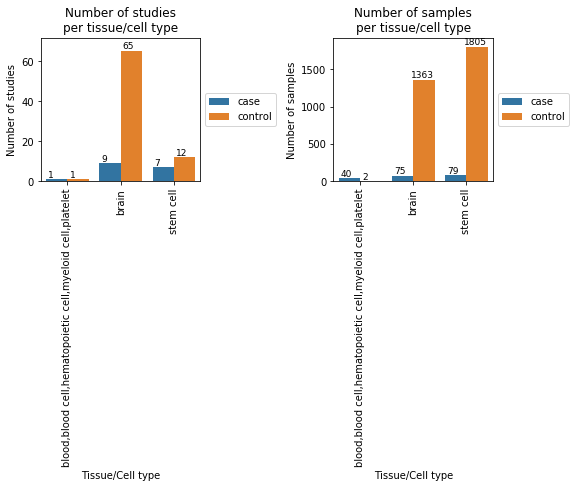

In [10]:
case, control = term_to_run(sample_to_terms, term)
ret = match_case_to_controls(term, control, case, sample_to_terms,
    sample_to_study, blacklist_terms, term_name_to_id, sample_to_type,
    filter_poor=True, filter_cell_line=True, filter_differentiated=True,
    sample_to_runs=sample_to_runs, by_run=False)
df = ret[0]
control_confound = ret[1]
case_confound = ret[2]
tissue_intersections = ret[3]

create_summary_plots(df)
plt.show()

__5. Browse other metadata terms that are associated with cases and controls.__ 

Enter whether you want to view cases or controls. Assign the following variable to `True` to view cases or `False` to view controls.

In [11]:
view_cases = False ## <-- INPUT HERE

Enter the tissue or cell type on which to subset your samples:

In [12]:
term = 'brain' ## <-- INPUT HERE

if view_cases:
    condition = 'case'
else:
    condition = 'control'
view_exps = select_case_control_experiment_set(df, condition, term)
with open('./data/term-in.json', 'w') as f:
    json.dump(view_exps, f)

The following plots the proportion of metadata terms for those terms that appear in at least 10% of the samples in the current subset:

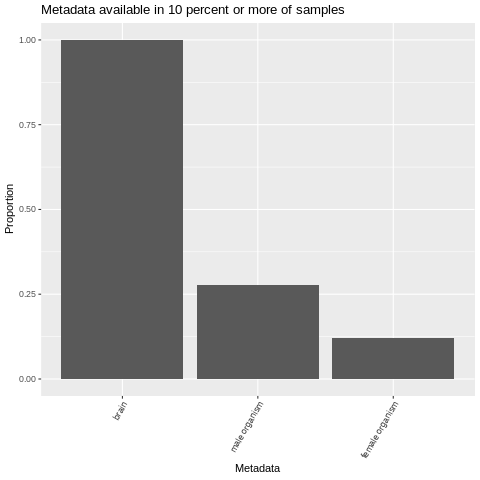

In [13]:
%%R
source("./Metadata_plot.R")
bp

In [14]:
%%R
source("./Metadata_table.R")
query_disease_metadata_top10_table

         Metadata Sample Number Proportion
1           brain           710  1.0000000
2   male organism           196  0.2760563
3 female organism            85  0.1197183


         Var1 Freq  Metadata Proportion
632 cell line    0 cell line          0


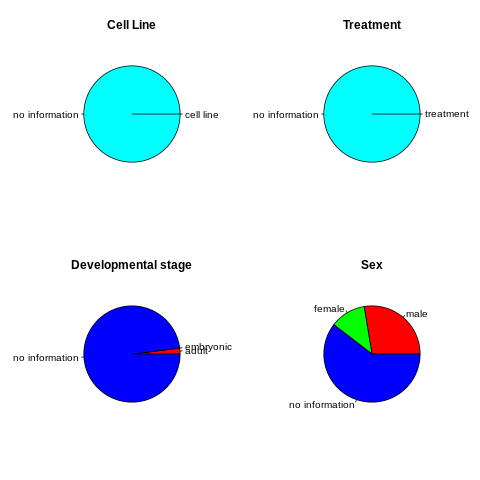

In [15]:
%%R
source("./Metadata_piecharts.R")
query_cell_line

__5. Create output file__

Enter the filename for which you would like to output these cases or controls:

In [16]:
output_file = 'cases_vs_controls.csv' ## <- OUTPUT FILE HERE

df.to_csv(output_file)